# Introduction

In this lab, we will explore the K-Means clustering algorithm using the scikit-learn library in Python. We will use the handwritten digits dataset, which contains 64 features representing an 8x8 image of a digit, and we will try to group the images together based on the digit they represent. We will compare the different initialization methods for K-Means and evaluate the performance of the clustering using various metrics.

# Load the Dataset

We will start by loading the digits dataset using scikit-learn's **load_digits()** function. This function returns the features and labels for the dataset.

In [2]:
import numpy as np
from sklearn.datasets import load_digits

data, labels = load_digits(return_X_y=True)
(n_samples, n_features), n_digits = data.shape, np.unique(labels).size

# Define the Evaluation Benchmark

We will define a benchmark to compare different initialization methods for K-Means. Our benchmark will:

- create a pipeline which will scale the data using a StandardScaler
- train and time the pipeline fitting
- measure the performance of the clustering obtained via different metrics

In [3]:
from time import time
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

def bench_k_means(kmeans, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A `KMeans` instance with the initialization already set.
    name : str
        Name given to the strategy. It will be used to show the results in a table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which require some supervision.
    """
    t0 = time()
    estimator = make_pipeline(StandardScaler(), kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

    # Define the metrics which require only the true labels and estimator labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=300,
        )
    ]

    # Show the results
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))

# Run the Benchmark

We will compare three approaches for initializing K-Means:

- an initialization using k-means++. This method is stochastic and we will run the initialization 4 times;
- a random initialization. This method is stochastic as well and we will run the initialization 4 times;
- an initialization based on a PCA projection. We will use the components of the PCA to initialize K-Means. This method is deterministic and a single initialization is sufficient.

In [4]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

print(82 * "_")
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")

kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans, "k-means++", data, labels)

kmeans = KMeans(init='random', n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans, "random", data, labels)

pca = PCA(n_components=n_digits).fit(data)
kmeans = KMeans(n_clusters=n_digits, n_init=1, random_state=0, init=pca.components_)
bench_k_means(kmeans, "PCA-based", data, labels)

print(82 * "_")

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.110s	69545	0.598	0.645	0.621	0.469	0.617	0.153
random   	0.024s	69735	0.681	0.723	0.701	0.574	0.698	0.195
PCA-based	0.008s	69513	0.600	0.647	0.622	0.468	0.618	0.163
__________________________________________________________________________________


# Visualize the Results on PCA-Reduced Data

We will use PCA to reduce the dataset to 2 dimensions and plot the data and clusters in this new space.

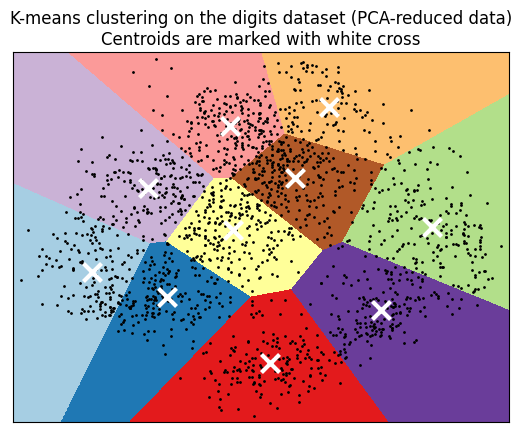

In [5]:
import matplotlib.pyplot as plt

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=4, random_state=0)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of th VQ.
h = 0.02 # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# obtain lables for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the results into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    linewidths=3,
    s=169,
    color='w',
    zorder=10,
)
plt.title(
    "K-means clustering on the digits dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

# Summary

In this lab, we explored the K-Means clustering algorithm and applied it to the handwritten digits dataset. We compared different initialization methods and evaluated the performance of the clustering using various metrics. We also visualized the results in a 2-dimensional space using PCA.